annotate network with validation from:
- gwas catalog
- mgd (not actually added as not wanted)
- gprofiler family

# import packages

In [1]:
from ndex2.nice_cx_network import NiceCXNetwork
import ndex2.client as nc
import ndex2
import networkx as nx
import pandas as pd
import numpy as np
import os
from netcoloc import netprop_zscore
from netcoloc import netprop
from netcoloc import network_colocalization
from scipy.stats import hypergeom
#import upsetplot
from upsetplot import plot as upplot
from upsetplot import from_contents
from upsetplot import UpSet

import matplotlib.pyplot as plt
from rca_functions import *

In [3]:
os.chdir('/tscc/nfs/home/bsleger/bsl/rare_common_alcohol/')

In [ ]:
save_fig=False

# import pcnet

In [ ]:
interactome=import_interactome(interactome_name='pcnet_v14')

# read in common and rare meta data

In [5]:
rare_datasets=pd.read_csv('rare_datasets_prepub.csv')
common_datasets=pd.read_csv('common_datasets_prepub.csv')

# choose network to analyze and import colocalized network

In [6]:
#set which network you're annotating
uuid_dict={'bonf_strin':'48de252c-3d50-11ee-aa50-005056ae23aa',
'FDR_25':'f81a3f67-4215-11ee-aa50-005056ae23aa'}

In [7]:
#read in network chosen above
analysis_dataset='FDR_25'
network = ndex2.create_nice_cx_from_server(server='public.ndexbio.org',username='bsleger',password='Pyjgor-3sarwe-puvfyb', uuid=uuid_dict[analysis_dataset])
nodes=list(nx.get_node_attributes(network, 'n').values())

In [8]:
#import families and HGNC for FDR_25 only
families=pd.read_csv('fdr25_tbl_families.csv')
families=families.drop('HGNC Symbol',axis=1)

# import rare and common variant network seed genes and zscores

In [9]:
rare_datasets['seed_path'][1]

'rare_variant_genebass/alcohol_intake/alcohol_intake_FDR_25.csv'

In [10]:
row_rare=1
seed_rare=pd.read_csv(rare_datasets['seed_path'][row_rare],sep=',')
seed_rare=list(seed_rare[rare_datasets['seed_gene_name'][row_rare]])
seed_rare=list(set(seed_rare))
label_rare=rare_datasets['label'][row_rare]
zscore_rare_df=pd.read_csv(rare_datasets['zscore_path'][row_rare],header=None, sep='\t')
zscore_rare_df.index=zscore_rare_df[0]
zscore_rare_df=zscore_rare_df.drop(columns=[0])
zscore_rare=zscore_rare_df[1].squeeze()
zscore_rare_df = pd.DataFrame({'z':zscore_rare})
print('analyzing '+rare_datasets['label'][row_rare])

analyzing alcoholintake_FDR_25


In [11]:
#import common variant network seed genes and zscores
row_common=4
label_common=common_datasets['label'][row_common]
if (common_datasets['delim'][row_common]=='tab'):
    seed_common=pd.read_csv(common_datasets['seed_path'][row_common],sep='\t')
else:
    seed_common=pd.read_csv(common_datasets['seed_path'][row_common],sep=',')

seed_common=seed_common[seed_common[common_datasets['seed_p'][row_common]]<0.05/len(seed_common)]
seed_common=list(seed_common[common_datasets['seed_gene_name'][row_common]])

zscore_common_df=pd.read_csv(common_datasets['zscore_path'][row_common],header=None, sep='\t')
zscore_common_df.index=zscore_common_df[0]
zscore_common_df=zscore_common_df.drop(columns=[0])
zscore_common=zscore_common_df[1].squeeze()
zscore_common_df = pd.DataFrame({'z':zscore_common})
print('analyzing '+common_datasets['label'][row_common])

analyzing GSCAN_DPW_magma


In [12]:
#seed_common.to_csv('magma_alcintake_sig_genes.csv')

In [13]:
#define zscore cutoffs used
cutoff_comb=3
cutoff_single=1.5

# query gwas catalog for network genes with alcohol traits

## import and format gwas catalog

In [16]:
gwas_catalog=pd.read_csv('gwas_catalog_v12.tsv',sep='\t',low_memory=False)

In [17]:
gwas_catalog['MAPPED_TRAIT']=gwas_catalog['MAPPED_TRAIT'].str.lower()
gwas_catalog['DISEASE/TRAIT']=gwas_catalog['DISEASE/TRAIT'].str.lower()

In [18]:
#filter genes that were mapped
mapped=gwas_catalog[~gwas_catalog['MAPPED_GENE'].isna()]
mapped=mapped[~mapped['MAPPED_TRAIT'].isna()]
mapped=mapped[['MAPPED_GENE','MAPPED_TRAIT','DISEASE/TRAIT']]
mapped.columns=['GENE','MAPPED_TRAIT','DISEASE/TRAIT']
#filter genes that were reported
rep=gwas_catalog[~gwas_catalog['REPORTED GENE(S)'].isna()]
rep=rep[~rep['MAPPED_TRAIT'].isna()]
rep=rep[~rep['REPORTED GENE(S)'].str.contains('Intergenic')]
rep=rep[['REPORTED GENE(S)','MAPPED_TRAIT','DISEASE/TRAIT']]
rep.columns=['GENE','MAPPED_TRAIT','DISEASE/TRAIT']

In [19]:
#combine mapped and reported into a singular table
cat=pd.concat([rep, mapped])
cat['GENE']=cat['GENE'].str.split('; ')
cat=cat.explode('GENE')
cat=cat[~(cat['GENE'].str.contains('mapped'))]
cat['GENE']=cat['GENE'].str.split(', ')
cat=cat.explode('GENE')
cat['GENE']=cat['GENE'].str.split(' - ')
cat=cat.explode('GENE')
cat['GENE']=cat['GENE'].astype('str')
cat=cat[~(cat['GENE'].str.contains('intergenic'))]
cat['TRAIT']=cat['MAPPED_TRAIT'] + ": " +cat['DISEASE/TRAIT']

In [20]:
#subset for alcohol use traits
alc_cat=cat[(cat['TRAIT'].str.contains('alcohol'))
            |(cat['TRAIT'].str.contains('drinking'))
           |(cat['TRAIT'].str.contains('wine'))
           |(cat['TRAIT'].str.contains('liquor'))
           |(cat['TRAIT'].str.contains('beer'))]
#include every measure- could also remove add wine, beer, liquor-doesnt change number of genes
alc_cat=alc_cat[~(alc_cat['TRAIT'].str.contains('nonalcohol'))]
alc_cat=alc_cat[~(alc_cat['TRAIT'].str.contains('non-alcohol'))]
alc_ls=alc_cat['TRAIT'].to_list()
alc_cat=alc_cat.groupby('GENE').agg(tuple).applymap(set).reset_index()
alc_cat=alc_cat[['GENE','TRAIT']]
alc=alc_cat[alc_cat['GENE'].isin(nodes)]

In [21]:
#subset for smoking traits
smok_cat=cat[(cat['TRAIT'].str.contains('smok'))&(~cat['TRAIT'].str.contains('taste'))]
#smok_cat['TRAIT']=smok_cat['MAPPED_TRAIT'] + ": " +smok_cat['DISEASE/TRAIT']
smok_ls=smok_cat['TRAIT'].to_list()
smok_cat=smok_cat.groupby('GENE').agg(tuple).applymap(set).reset_index()
smok_cat=smok_cat[['GENE','TRAIT']]
smok=smok_cat[smok_cat['GENE'].isin(nodes)]

In [22]:
SUD_cat=cat[
(cat['TRAIT'].str.contains('substance')
|cat['TRAIT'].str.contains('addiction')
|cat['TRAIT'].str.contains('cocaine')
|cat['TRAIT'].str.contains('opioid')
|cat['TRAIT'].str.contains('cannabis')
|cat['TRAIT'].str.contains('hallucinogen')
|cat['TRAIT'].str.contains('abuse')
|cat['TRAIT'].str.contains('dependence'))
&
((~cat['TRAIT'].str.contains('externalizing'))
&(~cat['TRAIT'].str.contains('food'))
&(~cat['TRAIT'].str.contains('internet'))
&(~cat['TRAIT'].str.contains('taste'))
&(~cat['TRAIT'].str.contains('eating'))
&(~cat['TRAIT'].str.contains('nicotine'))
&(~cat['TRAIT'].str.contains('alcohol'))
&(~cat['TRAIT'].str.contains('response to opioid')))
]
SUD_ls=SUD_cat['TRAIT'].tolist()
SUD_cat=SUD_cat.groupby('GENE').agg(tuple).applymap(set).reset_index()
SUD_cat=SUD_cat[['GENE','TRAIT']]
SUD=SUD_cat[SUD_cat['GENE'].isin(nodes)]

In [23]:
SUD

,GENE,TRAIT
13,ADH1B,{substance-related disorder: addiction risk fa...
152,EPM2A,{methadone dose measurement: methadone dose in...
156,EXOC2,{methadone dose measurement: methadone dose in...
176,FOXP2,"{cannabis dependence: cannabis use disorder, o..."
460,RABEP2,{cannabis use: cannabis use}
570,SNTB1,{opioid use measurement: opioid use cessation}
594,SYNJ2,{drug dependence: cannabis use (initiation)}
628,TXK,{opioid dependence: opioid addiction}


In [24]:
behav_ls=set(cat[
(cat['TRAIT'].str.contains('depre'))|
    (cat['TRAIT'].str.contains('neurotic'))|
    (cat['TRAIT'].str.contains('cogn'))|
    (cat['TRAIT'].str.contains('behav'))|
    (cat['TRAIT'].str.contains('anorex'))|
    ((cat['TRAIT'].str.contains('mani'))&(~cat['TRAIT'].str.contains('holdemania')))|
    (cat['TRAIT'].str.contains('parkinson'))|
    (cat['TRAIT'].str.contains('alz'))|
    (cat['TRAIT'].str.contains('language'))|
    (cat['TRAIT'].str.contains('risk'))|
    (cat['TRAIT'].str.contains('demen'))|
    (cat['TRAIT'].str.contains('autis'))|
    (cat['TRAIT'].str.contains('disorder')&~cat['TRAIT'].str.contains('use disorder'))|
    (cat['MAPPED_TRAIT'].str.contains('risk'))|
    (cat['TRAIT'].str.contains('anxiet'))|
    (cat['TRAIT'].str.contains('memory')&(~cat['TRAIT'].str.contains('cell')))|
    (cat['TRAIT'].str.contains('externalizing'))
]['TRAIT'])

SUD_inclusive=set(alc_ls+SUD_ls+smok_ls)
behav_ls=behav_ls.difference(set(SUD_inclusive))
behav_cat=cat[cat['TRAIT'].isin(behav_ls)]
behav_cat=behav_cat.groupby('GENE').agg(tuple).applymap(set).reset_index()
behav_cat=behav_cat[['GENE','TRAIT']]
behav=behav_cat[behav_cat['GENE'].isin(nodes)]

In [25]:
#check if use disorders present in listed phenotypes for behaviour
[x for x in behav_ls if 'use disorder' in x]

[]

## format gwas catalog traits into table to query

In [26]:
t=alc_cat.merge(smok_cat,on="GENE", how="outer")
t=t.merge(SUD_cat, on="GENE",how="outer")
t.columns=['GENE','ALC_TRAIT',
           'SMOK_TRAIT',
           'SUD_TRAIT']
t=t.merge(behav_cat, on="GENE",how="outer")
t.columns=['GENE','ALC_TRAIT',
           'SMOK_TRAIT',
           'SUD_TRAIT',
          'NEUROPSYCH_TRAIT']

In [27]:
t

,GENE,ALC_TRAIT,SMOK_TRAIT,SUD_TRAIT,NEUROPSYCH_TRAIT
0,A1CF,"{triglyceride measurement, alcohol consumption...",NaN,NaN,{cognitive function measurement: cognitive fun...
1,AADAT,{alcohol consumption measurement: alcohol cons...,NaN,NaN,{self reported educational attainment: noncogn...
2,AATF,{alcohol consumption measurement: drinks per w...,{smoking initiation: smoking initiation},NaN,NaN
3,ABCA1,"{alcohol consumption measurement, high density...","{smoking behavior, bmi-adjusted waist-hip rati...",NaN,"{posterior cortical atrophy, alzheimer disease..."
4,ABCA4,{aspartate aminotransferase measurement: aspar...,NaN,NaN,NaN
...,...,...,...,...,...
15090,ncRNA32,NaN,NaN,NaN,{mental deterioration: cognitive decline (age-...
15091,other genes,NaN,NaN,NaN,"{bipolar disorder, schizophrenia: bipolar diso..."
15092,snoZ13_snr52,NaN,NaN,NaN,"{unipolar depression: depression, anxiety meas..."
15093,snoZ6,NaN,NaN,NaN,"{alzheimer disease, family history of alzheime..."


In [28]:
#t.to_csv('MAGMA_FDR25_all_drug_associations.csv',index=False)

In [29]:
#SUD.to_csv('FDR25_magma_alcoholintake_SUD_gwascatalog_genes.csv')

In [30]:
#set(gwas_catalog_alc[gwas_catalog_alc['DISEASE/TRAIT'].str.contains(' in ')]['DISEASE/TRAIT'])

# import dataframe of gprofiler enrichment

In [31]:
gprof_dict={'bonf_strin':'gProfiler_hsapiens_8-11-2023_1-37-16 PM__intersections_rare_stin.csv',
          'FDR_25':'gProfiler_hsapiens_8-23-2023_5-47-43 PM__intersections_FDR25.csv'}

In [32]:
gprof=pd.read_csv(gprof_dict[analysis_dataset])

In [33]:
gprof=gprof[(gprof['term_size']<500) 
            &(gprof['term_size']>50)]

In [34]:
gprof['intersections']=gprof['intersections'].str.split(',')

In [35]:
gprof=gprof[gprof['adjusted_p_value']<1e-3]
gprof=gprof[gprof['source'].str.contains('GO')]

In [36]:
gprof_explode=gprof.explode('intersections').reset_index().drop('index',axis=1)

In [37]:
gprof_collapse=gprof_explode.loc[gprof_explode.groupby('intersections')['adjusted_p_value'].idxmin()]

In [38]:
set(gprof_collapse['term_name'])

{'UDP-glycosyltransferase activity',
 'alcohol metabolic process',
 'cellular aldehyde metabolic process',
 'cellular response to xenobiotic stimulus',
 'fatty acid metabolic process',
 'hexosyltransferase activity',
 'hormone metabolic process',
 'oxidoreductase activity, acting on the CH-OH group of donors, NAD or NADP as acceptor',
 'primary alcohol metabolic process',
 'response to xenobiotic stimulus',
 'steroid metabolic process',
 'terpenoid metabolic process',
 'xenobiotic metabolic process'}

# make dataframe to make into dictionaries for adding to network

In [39]:
df=pd.DataFrame(nodes)
df.columns=['nodes']

In [40]:
df['in_gwas_catalog']=df['nodes'].isin(cat['GENE'])
df['alc_val']=df['nodes'].isin(alc['GENE'])

In [41]:
df=df.merge(t, left_on='nodes',right_on='GENE',how='left')
df=df.merge(families,left_on='nodes',right_on='name',how='left')

In [42]:
df=df.drop(['GENE'],axis=1)

In [43]:
df=df.drop(['name'],axis=1)

In [80]:
#df.to_csv('updated_GWAS_cat_FDR25MAGMA.csv',index=False)

## merge gprofiler group label into dataframe of attributes

In [44]:
df=df.merge(gprof_collapse[['term_name','intersections']], left_on='nodes',right_on='intersections',how='left').drop('intersections',axis=1)

## make dataframe into dictionary and add node attributes to network

In [45]:
#necessary to replace NA to uploade to ndex
df=df.fillna('null')
df = df.astype(str)
#df.index=df['nodes']
df_dict=df.to_dict()
attributes=df.columns
attributes=attributes.drop('nodes')

In [46]:
#add attributes to network
for a in attributes:
    for i in network.nodes:
        network.set_node_attribute(node=i, attribute_name=a, type='string',values=df_dict[a][i])

In [185]:
df.to_csv('nodes_gwas_cat.csv',index=False)

## export network to ndex

In [186]:
network.set_name(network.get_name()+'_annotated')
#use to upload as new newtwork with annotated subscript
network.upload_to(server='public.ndexbio.org',
                  username='bsleger',
                  password='Pyjgor-3sarwe-puvfyb' )

Generating CX


'https://www.ndexbio.org/v2/network/5b6323bb-93a3-11ee-8a13-005056ae23aa'

In [239]:
network

# ID seed genes that have been found for GWAS traits

In [47]:
len(set(cat['GENE']))

38323

In [48]:
os.getcwd()

'/tscc/projects/ps-palmer/brittany/rare_common_alcohol'

In [49]:
t[t['GENE'].isin(seed_rare)].to_csv('gwas_catalog_rare_seed_FDR25.csv')

In [51]:
tbl=alc_cat[alc_cat['GENE'].isin(seed_rare)]
tbl=tbl.explode('TRAIT')

In [52]:
len(set(tbl[tbl.TRAIT.str.contains('consumption')]['GENE']))

12

In [53]:
SUD_rare=SUD_cat[SUD_cat['GENE'].isin(seed_rare)]

In [54]:
cat=cat.explode('GENE')

In [56]:
SUD_rare

,GENE,TRAIT
13,ADH1B,{substance-related disorder: addiction risk fa...
92,CHRM3,{hallucinations: hallucinations in long-term c...
183,GCKR,{opioid-binding protein/cell adhesion molecule...


# test if gwas catalog enrichment is significant 

In [ ]:
GWAS_catalog_pcnetnodes=set(list(gwas_catalog['REPORTED GENE(S)'].dropna())+list(gwas_catalog['MAPPED_GENE'])).intersection(pc_nodes)

In [ ]:
len(set(nodes).intersection(cat['GENE']))

## alcohol traits

In [44]:
#alcohol traits
hyper = hypergeom(M=len(GWAS_catalog_pcnetnodes), n=len(set(alc_cat['GENE']).intersection(pc_nodes)), N=len(nodes))
p_intersect_alc = hyper.sf(len(set(alc['GENE'])))
p_intersect_alc

0.0015553079797409979

In [45]:
len(set(alc['GENE']))

40

## smoking traits

In [46]:
hyper = hypergeom(M=len(set(GWAS_catalog_pcnetnodes)), n=len(set(smok_cat['GENE']).intersection(pc_nodes)), N=len(nodes))
p_intersect_smok = hyper.sf(len(set(smok['GENE'])))
p_intersect_smok

0.045814720229329295

In [47]:
len(set(smok['GENE']))

52

In [48]:
len(set(smok_cat['GENE']).intersection(pc_nodes))

2977

In [49]:
len(set(GWAS_catalog_pcnetnodes))

14539

## SUD traits

In [50]:
hyper = hypergeom(M=len(GWAS_catalog_pcnetnodes), n=len(set(SUD_cat['GENE']).intersection(pc_nodes)), N=len(nodes))
p_intersect_SUD = hyper.sf(len(set(SUD['GENE'])))
p_intersect_SUD

0.11831054996972501

In [393]:
set(SUD['GENE'])

{'ADH1B',
 'EPM2A',
 'FOXP1',
 'FOXP2',
 'HSP90AA1',
 'NFAT5',
 'SND1',
 'SULT1A2',
 'TXK',
 'XYLT1',
 'ZKSCAN5'}

In [52]:
SUD_incl_cat=(SUD_cat['GENE'].to_list()+other_SUD_cat['GENE'].to_list())

NameError: name 'other_SUD_cat' is not defined

In [51]:
hyper = hypergeom(M=len(GWAS_catalog_pcnetnodes), n=len(set(SUD_incl_cat).intersection(pc_nodes)), N=len(nodes))
p_intersect_SUD = hyper.sf(len(set(SUD_incl_cat).intersection(nodes)))
p_intersect_SUD

NameError: name 'SUD_incl_cat' is not defined

In [208]:
len(set(SUD_incl_cat).intersection(nodes))

15

In [209]:
len(SUD['GENE'])

11

In [210]:
len(GWAS_catalog_pcnetnodes)

14539

In [211]:
len(set(smok_cat['GENE']).intersection(pc_nodes))

2977

In [212]:
len(set(SUD['GENE']))

11

In [102]:
smok.merge(SUD, on='GENE', how='outer').to_csv('node_SUD_smok_phenotypes.csv')

In [394]:
t.to_csv("behavioural_and_SUD_traits_GWAS_catalog.csv",index=False)

# behavioural traits

In [67]:
behav_exp_cat=cat[cat['TRAIT'].isin(behav_ls)]
behav_exp=behav_exp_cat[behav_exp_cat['GENE'].isin(nodes)]

In [68]:
behav_exp

,GENE,MAPPED_TRAIT,DISEASE/TRAIT,TRAIT
7006,HIPK3,aggressive behavior,anger,aggressive behavior: anger
10650,SLC4A8,"unipolar depression, mood disorder, response t...",response to antidepressants and depression,"unipolar depression, mood disorder, response t..."
20580,CEP85L,"attention deficit hyperactivity disorder, bipo...",bipolar disorder (age of onset <21) or attenti...,"attention deficit hyperactivity disorder, bipo..."
20586,CEP85L,"attention deficit hyperactivity disorder, bipo...",bipolar disorder or attention deficit hyperact...,"attention deficit hyperactivity disorder, bipo..."
20597,CEP85L,"attention deficit hyperactivity disorder, bipo...",bipolar disorder or attention deficit hyperact...,"attention deficit hyperactivity disorder, bipo..."
...,...,...,...,...
480807,TTC21B,cognitive function measurement,cognitive performance (mtag),cognitive function measurement: cognitive perf...
501921,SH3BP4,memory performance,cognitive function (delayed memory),memory performance: cognitive function (delaye...
502118,EXOC2,memory performance,cognitive function (immediate memory) (longitu...,memory performance: cognitive function (immedi...
502879,EXOC2,memory performance,cognitive function (immediate memory),memory performance: cognitive function (immedi...


In [64]:
depr=behav[behav['TRAIT'].str.contains('depr')]
depr_cat=behav_cat[behav_cat['TRAIT'].str.contains('depr')]

KeyError: "None of [Float64Index([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,\n              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,\n              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,\n              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,\n              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,\n              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,\n              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],\n             dtype='float64')] are in the [columns]"

In [33]:
bip=behav[behav['TRAIT'].str.contains('bipol')]
bip_cat=behav_cat[behav_cat['TRAIT'].str.contains('bipol')]

In [37]:
schiz=behav[behav['TRAIT'].str.contains('schiz')]
schiz_cat=behav_cat[behav_cat['TRAIT'].str.contains('schiz')]

In [39]:
set(schiz['TRAIT'])

{'antipsychotic drug use measurement: antipsychotic drug dosage in schizophrenia or schizoaffective disorder',
 'attention deficit hyperactivity disorder, unipolar depression, bipolar disorder, autism spectrum disorder, schizophrenia: autism spectrum disorder, attention deficit-hyperactivity disorder, bipolar disorder, major depressive disorder, and schizophrenia (combined)',
 'autism spectrum disorder, schizophrenia: autism spectrum disorder or schizophrenia',
 'disease recurrence, unipolar depression, bipolar disorder, schizophrenia: schizophrenia, bipolar disorder or recurrent major depressive disorder',
 'mental or behavioural disorder: bipolar disorder and schizophrenia',
 'obsessive-compulsive disorder, attention deficit hyperactivity disorder, tourette syndrome, unipolar depression, bipolar disorder, autism spectrum disorder, schizophrenia, anorexia nervosa: anorexia nervosa, attention-deficit/hyperactivity disorder, autism spectrum disorder, bipolar disorder, major depression, 

In [34]:
len(set(bip['GENE']))

15

In [30]:
len(set(depr_cat['GENE']))

3163

In [32]:
hyper = hypergeom(M=len(GWAS_catalog_pcnetnodes), n=len((set(depr_cat['GENE'])).intersection(pc_nodes)), N=len(nodes))
p_intersect_behav = hyper.sf(len(set(depr['GENE'])))
p_intersect_behav

0.8844735920480864

In [40]:
hyper = hypergeom(M=len(GWAS_catalog_pcnetnodes), n=len((set(schiz_cat['GENE'])).intersection(pc_nodes)), N=len(nodes))
p_intersect_behav = hyper.sf(len(set(schiz['GENE'])))
p_intersect_behav

0.8198871722341952

In [36]:
hyper = hypergeom(M=len(GWAS_catalog_pcnetnodes), n=len((set(bip_cat['GENE'])).intersection(pc_nodes)), N=len(nodes))
p_intersect_behav = hyper.sf(len(set(bip['GENE'])))
p_intersect_behav

0.7643888807319352

# FUMA Gene to Function - integrate into network

In [142]:
#downloaded from FUMA- server
#general= 30 tissues
#other is 54 tissues
gtex_30_dict={'FDR_25':'FUMA_gene2func_fdr25_alcoholintake_network/gtex_v8_ts_general_DEG.txt'}
gtex_54_dict={'FDR_25':'FUMA_gene2func_fdr25_alcoholintake_network/gtex_v8_ts_DEG_annotatedsystem.txt'}
gtex_gene_table_dict={'FDR_25':'FUMA_gene2func_fdr25_alcoholintake_network/geneTable.txt'}

In [143]:
gtex30=pd.read_csv(gtex_30_dict[analysis_dataset], sep='\t')
gtex54=pd.read_csv(gtex_54_dict[analysis_dataset], sep='\t')
gtex_meta=pd.read_csv(gtex_gene_table_dict[analysis_dataset], sep='\t')
gtex_meta.index=gtex_meta.ensg

In [144]:
gtex_dict=gtex_meta[['symbol']].to_dict

## gtex 30 tissue

In [145]:
gtex30_sig=gtex30[gtex30['adjP']<0.05]

In [146]:
twoside=gtex30_sig[gtex30_sig['Category']=='DEG.twoside']['GeneSet']

In [147]:
up=gtex30_sig[gtex30_sig['Category']=='DEG.up']['GeneSet']

In [148]:
down=gtex30_sig[gtex30_sig['Category']=='DEG.down']['GeneSet']

In [149]:
down

33             Blood
41             Heart
42            Kidney
43             Liver
45            Muscle
48          Pancreas
51    Salivary_Gland
54            Spleen
59            Vagina
Name: GeneSet, dtype: object

In [285]:
up

8               Colon
12             Kidney
13              Liver
23    Small_Intestine
25            Stomach
Name: GeneSet, dtype: object

In [286]:
twoside=list(twoside)
twoside

['Adrenal_Gland',
 'Bladder',
 'Blood',
 'Colon',
 'Heart',
 'Kidney',
 'Liver',
 'Muscle',
 'Pancreas',
 'Salivary_Gland',
 'Skin',
 'Small_Intestine',
 'Stomach',
 'Vagina']

## gtex 54 tissue

In [150]:
gtex54_sig=gtex54[gtex54['adjP']<0.05]

In [151]:
twoside=gtex54_sig[gtex54_sig['Category']=='DEG.twoside']['GeneSet']

In [152]:
up=gtex54_sig[gtex54_sig['Category']=='DEG.up']['GeneSet']

In [153]:
down=gtex54_sig[gtex54_sig['Category']=='DEG.down']['GeneSet']

In [154]:
gtex54_sig=gtex54_sig[gtex54_sig['Category']=='DEG.twoside']

In [155]:
gtex54_sig['genes']=gtex54_sig['genes'].str.split(':')

In [156]:
gtex54_sig_exp=gtex54_sig.explode('genes')

In [157]:
gtex54_sig_exp=gtex54_sig_exp.merge(gtex_meta[['symbol']], left_on='genes', right_on='ensg',how='left')

In [158]:
set(gtex54_sig_exp['GeneSet'])

{'Adrenal_Gland',
 'Bladder',
 'Brain_Amygdala',
 'Brain_Anterior_cingulate_cortex_BA24',
 'Brain_Caudate_basal_ganglia',
 'Brain_Cerebellar_Hemisphere',
 'Brain_Cerebellum',
 'Brain_Cortex',
 'Brain_Frontal_Cortex_BA9',
 'Brain_Hippocampus',
 'Brain_Hypothalamus',
 'Brain_Nucleus_accumbens_basal_ganglia',
 'Brain_Putamen_basal_ganglia',
 'Brain_Spinal_cord_cervical_c-1',
 'Brain_Substantia_nigra',
 'Cells_Cultured_fibroblasts',
 'Colon_Transverse',
 'Esophagus_Mucosa',
 'Heart_Atrial_Appendage',
 'Heart_Left_Ventricle',
 'Kidney_Cortex',
 'Liver',
 'Minor_Salivary_Gland',
 'Muscle_Skeletal',
 'Pancreas',
 'Skin_Not_Sun_Exposed_Suprapubic',
 'Skin_Sun_Exposed_Lower_leg',
 'Small_Intestine_Terminal_Ileum',
 'Stomach',
 'Whole_Blood'}

In [168]:
set(gtex54['System'])

{'NS', 'cardiac', 'epidermal', 'gastro', nan, 'neuro', 'other', 'urinary'}

In [74]:
gtex54_sig_collapse=gtex54_sig_exp[['symbol','GeneSet','adjP']]

In [24]:
gtex54_sig_collapse=gtex54_sig_collapse.groupby('symbol').agg(tuple).applymap(list).reset_index()

In [25]:
gtex54_sig_collapse['N_GeneSet']=gtex54_sig_collapse['GeneSet'].apply(lambda x: len(x))

In [26]:
gtex54_sig_collapse[list(range(3,len(twoside)+3))]=False
gtex54_sig_collapse.columns=['symbol','GeneSet','adjP','N_Geneset']+list(twoside)

In [300]:
for i in twoside:
    #print(i)
    #print(gtex54_sig_collapse[i])
    for j in range(len(gtex54_sig_collapse)):
        gtex54_sig_collapse[i].iloc[j] = i in gtex54_sig_collapse['GeneSet'][j]

/scratch/bsleger/33523284.tscc-mgr7.local/ipykernel_5448/2842143822.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gtex54_sig_collapse[i].iloc[j] = i in gtex54_sig_collapse['GeneSet'][j]


## Plot gene FUMA DEG

In [224]:
twoside_tbl=gtex54[gtex54['Category']=='DEG.twoside']
twoside_tbl=twoside_tbl.sort_values("adjP", ascending=True)
#twoside_tbl=twoside_tbl[twoside_tbl['adjP']<1]

In [222]:
tiss_col_dict={'neuro':'#785EF0','gastro':'#FFB000','cardiac':'#D41A75', 'urinary':'#FFDF58','epidermal':'#6BABFF','other':'#FF7D2D', 'NS':"#CCCCCC",}

In [225]:
twoside_tbl['colour']=twoside_tbl['System'].apply(lambda x: tiss_col_dict.get(x))

In [210]:
plt.rcParams.update({'font.size': 10})

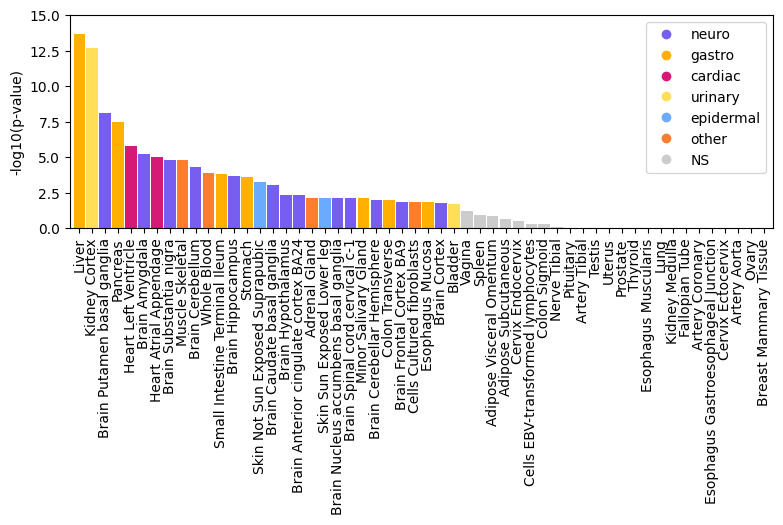

In [227]:
fig=plt.figure(figsize=(7.5,5))
fig=plt.bar(twoside_tbl['GeneSet'].str.replace('_',' '), -np.log10(twoside_tbl['adjP']), width=.9, align='center', color=twoside_tbl['colour'])
fig=plt.xticks(rotation=90)
fig=plt.ylabel('-log10(p-value)')
fig=plt.ylim([0,15])
fig=plt.tight_layout(pad=0)
fig=plt.margins(x=0.005)

# create legend
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in tiss_col_dict.values()]
plt.legend(markers, tiss_col_dict.keys(), numpoints=1)

plt.savefig('figures/' + 'gtex_enrichment_barplot_expanded.svg',bbox_inches='tight')

# make dataframe to make into dictionaries for adding to network

In [72]:
df=pd.DataFrame(nodes)
df.columns=['nodes']

In [73]:
df=df.merge(gtex54_sig_collapse, left_on='nodes',right_on='symbol',how='left')

NameError: name 'gtex54_sig_collapse' is not defined

In [74]:
df=df.drop(['symbol'],axis=1)

KeyError: "['symbol'] not found in axis"

In [ ]:
df

## make dataframe into dictionary and add node attributes to network

In [305]:
#necessary to replace NA to uploade to ndex
df=df.fillna('null')
df = df.astype(str)
#df.index=df['nodes']
df_dict=df.to_dict()
attributes=df.columns
attributes=attributes.drop('nodes')

In [306]:
#add attributes to network
for a in attributes:
    for i in network.nodes:
        network.set_node_attribute(node=i, attribute_name=a, type='string',values=df_dict[a][i])

In [308]:
network.get_node_attributes(25)

[{'po': 25, 'n': 'HGNC Symbol', 'v': 'SLC5A6'},
 {'po': 25,
  'n': 'z_alcoholintake_FDR_25',
  'v': '2.258363338262249',
  'd': 'double'},
 {'po': 25,
  'n': 'z_GSCAN_DPW_magma',
  'v': '13.762914916228087',
  'd': 'double'},
 {'po': 25, 'n': 'z_comb', 'v': '31.081662474432164', 'd': 'double'},
 {'po': 25, 'n': 'seed_alcoholintake_FDR_25', 'v': 'false', 'd': 'boolean'},
 {'po': 25, 'n': 'seed_GSCAN_DPW_magma', 'v': 'true', 'd': 'boolean'},
 {'po': 25, 'n': 'seed_both', 'v': 'false', 'd': 'boolean'},
 {'po': 25, 'n': 'seed_color_scheme', 'v': '2', 'd': 'integer'},
 {'po': 25, 'n': 'in_gwas_catalog', 'v': 'True', 'd': 'string'},
 {'po': 25, 'n': 'alc_val', 'v': 'False', 'd': 'string'},
 {'po': 25, 'n': 'DISEASE/TRAIT', 'v': 'null', 'd': 'string'},
 {'po': 25, 'n': 'MAPPED_TRAIT', 'v': 'null', 'd': 'string'},
 {'po': 25, 'n': 'SMOK_DISEASE/TRAIT', 'v': 'null', 'd': 'string'},
 {'po': 25, 'n': 'SMOK_MAPPED_TRAIT', 'v': 'null', 'd': 'string'},
 {'po': 25, 'n': 'SUD_DISEASE/TRAIT', 'v': 'nul

## export network to ndex

In [26]:
network.set_name(network.get_name()+'_updated_GWAS_catalog_and_tissue_enrichment')
#use to upload as new newtwork with annotated subscript
network.upload_to(server='public.ndexbio.org',
                  username='bsleger',
                  password='Pyjgor-3sarwe-puvfyb' )

Generating CX


'https://www.ndexbio.org/v2/network/a7e0fd9e-b189-11ee-8a13-005056ae23aa'

# check seed gene validation in GWAS catalog

## build tables and export

In [57]:
rare_seed_df = pd.DataFrame({'GENE': seed_rare})
rare_seed_df=rare_seed_df.merge(t, on='GENE',how='left')
rare_seed_df.to_csv("FDR_25_seed_GWAS_catalog.csv",sep=",",index=False)

In [58]:
common_seed_df = pd.DataFrame({'GENE': seed_common})
common_seed_df=common_seed_df.merge(t, on='GENE',how='left')
common_seed_df.to_csv("GSCAN_MAGMA_seed_GWAS_catalog.csv",sep=",",index=False)

## test significance

In [30]:
alc_cat_rare_seed=alc_cat[alc_cat['GENE'].isin(seed_rare)]

In [31]:
alc_cat_common_seed=alc_cat[alc_cat['GENE'].isin(seed_common)]

In [32]:
len(seed_common)

294

In [33]:
#alcohol traits
hyper = hypergeom(M=len(set(cat['GENE'])), n=len(set(cat['GENE']).intersection(seed_rare)), N=len(seed_rare))
p_intersect_alc = hyper.sf(len(set(cat['GENE']).intersection(alc_cat_rare_seed['GENE'])))
p_intersect_alc

8.237041662393227e-33

In [34]:
#alcohol traits
hyper = hypergeom(M=len(set(cat['GENE'])), n=len(set(cat['GENE']).intersection(seed_common)), N=len(seed_common))
p_intersect_alc = hyper.sf(len(set(cat['GENE']).intersection(alc_cat_common_seed['GENE'])))
p_intersect_alc

5.57868606e-316

In [35]:
len(seed_rare)

35

In [36]:
len(set(cat['GENE']).intersection(seed_rare))

32

In [37]:
len(set(cat['GENE']))

38323

In [38]:
len(set(cat['GENE']).intersection(alc_cat_rare_seed['GENE']))

12

In [39]:
len(set(cat['GENE']).intersection(seed_rare))

32

In [25]:
rare_seed_tbl=pd.read_csv('rare_variant_genebass/alcohol_intake/alcohol_intake_FDR_25_full_table.csv')

In [33]:
alc_cat_rare_seed_tbl=rare_seed_tbl.merge(alc_cat_rare_seed, left_on='Gene Name',right_on='GENE', how='outer')

In [34]:
alc_cat_rare_seed_tbl.to_csv('alcohol_intake_FDR25_gwas_catalog_alcohol_val.csv', index=False)

# upset plot- GWAS catalog

In [84]:
gwascat=from_contents({
    'alcohol':list(set(alc['GENE'])),
    'nicotine':list(set(smok['GENE'])),
    'SUD':list(set(SUD['GENE'])),
    'psychiatric':list(set(behav['GENE']))  
})

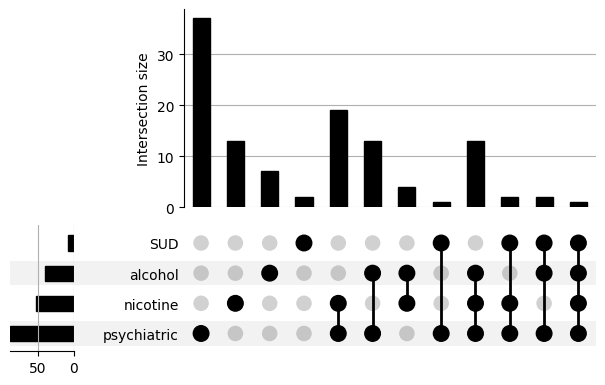

In [90]:
UpSet(gwascat, subset_size='count').plot()
#plt.savefig('figures/' + 'gwas_catalog_test_upset.pdf')
plt.savefig('figures/' + 'gwas_catalog_test_upset.svg')

# look at the stats for network nodes

In [30]:
node_stat=pd.read_csv('network_node_stats.csv')

In [32]:
node_stat.index=node_stat['HGNC Symbol']

In [59]:
node_stat.columns

Index(['AverageShortestPathLength', 'BetweennessCentrality',
       'ClosenessCentrality', 'ClusteringCoefficient', 'Degree',
       'Eccentricity', 'HGNC Symbol', 'in_gwas_catalog', 'IsSingleNode',
       'name', 'NeighborhoodConnectivity', 'NumberOfDirectedEdges',
       'NumberOfUndirectedEdges', 'PartnerOfMultiEdgedNodePairs', 'Radiality',
       'seed_alcoholintake_FDR_25', 'seed_both', 'seed_GSCAN_DPW_magma',
       'Stress', 'TopologicalCoefficient', 'z_alcoholintake_FDR_25', 'z_comb',
       'z_GSCAN_DPW_magma'],
      dtype='object')

In [60]:
node_stat

,AverageShortestPathLength,BetweennessCentrality,ClosenessCentrality,ClusteringCoefficient,Degree,Eccentricity,HGNC Symbol,in_gwas_catalog,IsSingleNode,name,...,PartnerOfMultiEdgedNodePairs,Radiality,seed_alcoholintake_FDR_25,seed_both,seed_GSCAN_DPW_magma,Stress,TopologicalCoefficient,z_alcoholintake_FDR_25,z_comb,z_GSCAN_DPW_magma
HGNC Symbol,,,,,,,,,,,,,,,,,,,,,
STAM2,3.201031,0.007888,0.312399,0.200000,6,5,STAM2,True,False,STAM2,...,0,0.966138,False,False,True,1252,0.250000,1.972590,30.904404,15.666915
SH3BP4,3.917526,0.000000,0.255263,1.000000,2,6,SH3BP4,True,False,SH3BP4,...,0,0.955115,False,False,False,0,0.590909,3.633693,5.745996,1.581310
OTUD6B,3.304124,0.001219,0.302652,0.333333,3,6,OTUD6B,True,False,OTUD6B,...,0,0.964552,False,False,False,290,0.400000,1.579771,3.002740,1.900744
RAD23A,2.943299,0.007261,0.339755,0.200000,5,5,RAD23A,True,False,RAD23A,...,0,0.970103,False,False,False,1658,0.245455,1.637132,4.084231,2.494747
HSP90AA1,2.077320,0.203004,0.481390,0.126126,37,4,HSP90AA1,True,False,HSP90AA1,...,0,0.983426,False,False,False,50480,0.110636,1.880207,4.477315,2.381288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
APOC4,2.938144,0.000337,0.340351,0.466667,6,5,APOC4,True,False,APOC4,...,0,0.970182,False,False,False,108,0.475556,1.807657,4.683831,2.591106
ADH1C,2.494845,0.018579,0.400826,0.473077,40,5,ADH1C,True,False,ADH1C,...,0,0.977002,True,True,True,6946,0.303495,8.544530,70.962884,8.305066
KIF12,4.989691,0.000000,0.200413,0.000000,1,8,KIF12,True,False,KIF12,...,0,0.938620,False,False,False,0,0.000000,2.626023,5.110822,1.946222


In [61]:
np.mean(node_stat['Radiality'])

11.01923076923077

In [45]:
nodes_stat_met=node_stat[node_stat['HGNC Symbol'].str.contains('CYP')|
node_stat['HGNC Symbol'].str.contains('ALD')|
node_stat['HGNC Symbol'].str.contains('ADH')|
node_stat['HGNC Symbol'].str.contains('UGT')|
node_stat['HGNC Symbol'].str.contains('SULT')]

In [66]:
nodes_stat_met['BetweennessCentrality']>np.mean(node_stat['BetweennessCentrality'])

HGNC Symbol
ADH5        True
ALDH3B1    False
CYP3A5     False
UGT2B7     False
ALDH2       True
ALDH1A2     True
ALDH6A1    False
CYP2E1      True
ALDH3A1    False
ADH6        True
ALDH1A1     True
ALDH1A3     True
CYP2A13    False
ADH7        True
ADH1B       True
SULT1A2    False
CYP3A43     True
CYP2B6      True
CYP2C18     True
SULT1A1     True
ADH1A       True
ADHFE1     False
UGT2B15    False
ADH4        True
UGT2B4     False
UGT1A10    False
UGT3A2     False
UGT2A3     False
UGT1A8     False
UGT1A9     False
UGT1A5     False
UGT1A4     False
UGT1A7     False
UGT1A1     False
UGT1A6      True
UGT1A3     False
UGT2B17    False
UGT2B10    False
UGT2B28    False
UGT2A1     False
ADH1C       True
Name: BetweennessCentrality, dtype: bool

In [85]:
df[~df['nodes'].isin(nodes_stat_met['HGNC Symbol'])].to_csv('network_nodes_gwascat_noalcmet.csv', index=False, quoting=None)

In [86]:
df

,nodes,in_gwas_catalog,alc_val,ALC_TRAIT,SMOK_TRAIT,SUD_TRAIT,NEUROPSYCH_TRAIT,Approved name,family
0,STAM2,True,False,NaN,{smoking status measurement: smoking initiatio...,NaN,{intelligence: general cognitive ability},NaN,NaN
1,SH3BP4,True,False,NaN,{unipolar depression: depression in smokers},NaN,{memory performance: cognitive function (delay...,SH3 domain binding protein 4,NaN
2,OTUD6B,True,False,NaN,NaN,NaN,NaN,NaN,NaN
3,RAD23A,True,False,NaN,NaN,NaN,NaN,NaN,NaN
4,HSP90AA1,True,True,"{nicotine use, generational effect measurement...",{smoking initiation: smoking initiation},NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
203,APOC4,True,False,NaN,NaN,NaN,{t-tau measurement: cerebrospinal fluid t-tau ...,NaN,NaN
204,ADH1C,True,True,{alcohol consumption measurement: alcohol cons...,NaN,NaN,"{parental emotion expression measurmement, con...","alcohol dehydrogenase 1C (class I), gamma poly...",alcohol dehydrogenase
205,KIF12,True,False,NaN,NaN,NaN,{cognitive decline measurement: rate of cognit...,NaN,NaN
206,LRRC37A2,True,False,NaN,NaN,NaN,{post-traumatic stress disorder symptom measur...,NaN,NaN


In [89]:
y=pd.read_csv('Rare-Common Alcohol Consumption Tables - stable 4. Alcohol Consumption Network Nodes.csv')

In [91]:
y[~y['HGNC Symbol'].isin(nodes_stat_met['HGNC Symbol'])].to_csv('network_nodes_gwascat_noalcmet.csv', index=False, quoting=None)